# Local coherence effects in SOSP for ICCM 2018

For this case, we only need two dimensions: we assume that the parser has already input and formed a partial parse up to *The coach smiled at the player tossed/thrown*. The first dimension is the strength of the link connecting *tossed/thrown* to *player*, and the second dimension codes the link connecting *player* to the subject dependent site on *tossed/thrown*.

The attractors are at [1, 0] (grammatical) and [0, 1] (local coherence, lc). [0, 1] gets has $h_1 = 2/3$ for *tossed* and $h_1 = 1/3$ for *thrown*. The grammatical [1, 0] always gets $h_0 = 1.0$.

I make the following assumptions about the features **REVISE**:

- *tossed* condition:
  - Head features on *player*: +Noun, -Moved
  - Subject dependent features on the verb: +Noun, -Moved
  - Head features on verb: +Verb, 0Participle (not specified one way or the other)
  - Modifier dependent features on *player*: +Verb, +Participle

- *thrown* condition:
  - Head features on *player*: +Noun, -Moved
  - Subject dependent features on the verb: +Noun, +Moved (the reduced relative should have a subject that's not in-situ).
  - Head features on verb: +Verb, +Participle
  - Modifier dependent features on *player*: +Verb, +Participle
  
$h_1$ is the harmony of the locally coherent (lc) parse; $h_0$ is the correct parse. I add a little bit of harmony to the locally coherent parse in the *thrown* condition because otherwise the harmony would be 0. We can think of this as there being other features present that boost the harmony some, although overall it's still a bad parse.

Below, I start the system at [0.1, 0.1] because starting it at [0, 0] seemed to allow the system to wander away from the two parses due to the noise.

In [1]:
# Running the Monte-Carlo simulations
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

centers = np.array([[1, 0], [0, 1]])
harmonies = np.array([1.0, 1.])
gamma = 0.25
ndim = centers.shape[1]
D = 0.001  # Small noise
maxsteps = 1000
tau = 0.01  # time step size
xinit = np.array([0, 0.])  # starting at the midpoint between the two attractors


# Defining functions
def phi(x, center, gamma):
    """RBF centers"""
    l2norm = np.linalg.norm(x - center)
    return np.exp(-l2norm**2 / gamma)


def calc_harmony(x, centers, harmonies, gamma):
    """Calculate the harmony at a given position"""
    harmony = 0
    for c in range(centers.shape[0]):
        harmony += harmonies[c] * phi(x, centers[c], gamma)
    return harmony


def step_dyn(x, centers, harmonies, gamma):
    """Iterate the discretized dynamics"""
    dx = np.zeros(x.shape)
    mult = -2./gamma
    for c in range(centers.shape[0]):
        dx += (mult * harmonies[c]
               * (x - centers[c]) * phi(x, centers[c], gamma))
    return dx


def not_close(x, centers, tol):
    """Returns True if not close to one of the centers"""
    l2norm = np.zeros(centers.shape[0])
    for c in range(centers.shape[0]):
        diff = x - centers[c]
        l2norm[c] = np.sqrt(np.dot(diff, diff))
    if np.any(l2norm < tol):
        return False
    else:
        return True

# Running
xhist = np.zeros((maxsteps, ndim))
nruns = 1000
data_list = []
cond = np.array([0.75, 0.5])

for h in range(len(cond)):
    harmonies[1] = cond[h]
    print('\nh_1 = {}'.format(cond[h]))
    for run in range(nruns):
        if run % 250 == 0:
            print('[{}] '.format(run), end='')
        xhist[0,] = xinit
        noise = np.random.normal(0, 1, xhist.shape)
        t = 0
        while t < maxsteps-1:
            if not_close(xhist[t], centers, 0.1):
                xhist[t+1,] = (xhist[t,] + tau*step_dyn(xhist[t,], centers, harmonies, gamma)
                              + np.sqrt(2*D*tau)*noise[t,])
                t += 1
            else:
                break
        if np.all(np.round(xhist[t,]) == centers[0,]):
            data_list.append([cond[h], 'gramm', t])
        elif np.all(np.round(xhist[t,]) == centers[1,]):
            data_list.append([cond[h], 'lc', t])
        else:
            data_list.append([cond[h], 'Other', t])

    if nruns == 1:
        plt.plot(xhist[:,0], xhist[:,1])
        plt.xlim(0, 1)
        plt.ylim(0, 1)
        plt.show()

data = pd.concat([pd.DataFrame([i], columns=('Harmony1', 'Attractor', 'Time')) for i in data_list])


h_1 = 0.75
[0] [250] [500] [750] 
h_1 = 0.5
[0] [250] [500] [750] 

In [2]:
# Checking to make sure it saved alright
print(data.head())
print(data.tail())

   Harmony1 Attractor  Time
0      0.75     gramm   160
0      0.75     gramm   176
0      0.75     gramm   147
0      0.75     gramm   134
0      0.75     gramm   129
   Harmony1 Attractor  Time
0       0.5     gramm   156
0       0.5     gramm   130
0       0.5     gramm   132
0       0.5     gramm   153
0       0.5     gramm   159


In [3]:
# Basic descriptive statistics
data.groupby('Harmony1').describe()

Time                                                       
           count     mean        std    min    25%    50%    75%    max
Harmony1                                                               
0.50      1000.0  149.549  23.708684   99.0  134.0  146.0  161.0  283.0
0.75      1000.0  157.605  27.817922  104.0  138.0  153.0  173.0  337.0

In [4]:
# basic info by attractor
data.groupby(['Harmony1', 'Attractor']).describe()

Time                                               \
                    count        mean        std    min     25%    50%   
Harmony1 Attractor                                                       
0.50     gramm      996.0  149.133534  22.801508   99.0  134.00  146.0   
         lc           4.0  253.000000  20.412415  238.0  241.75  245.5   
0.75     gramm      873.0  152.572738  23.746550  104.0  136.00  149.0   
         lc         127.0  192.196850  29.177628  141.0  170.50  190.0   

                                   
                       75%    max  
Harmony1 Attractor                 
0.50     gramm      161.00  271.0  
         lc         256.75  283.0  
0.75     gramm      165.00  262.0  
         lc         208.00  337.0

Here, I plot the harmony landscapes. The contours in each plot show the harmony values.

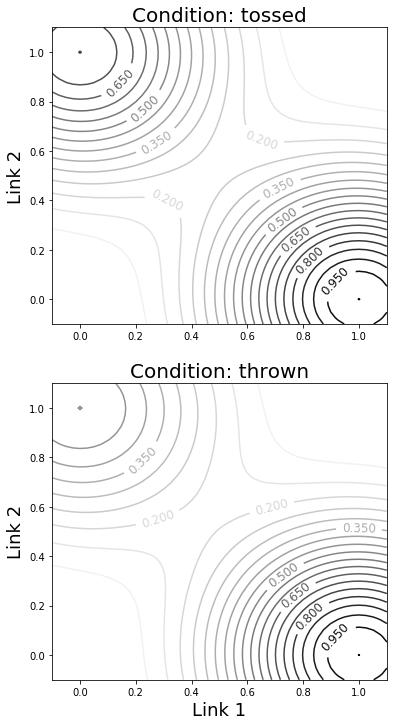

In [5]:
# Looking at the harmony landscape; only works for 2D
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

conditions = ['tossed', 'thrown']
delta = 0.025
x1 = np.arange(-0.1, 1.1, delta)
x2 = np.arange(-0.1, 1.1, delta)
f, axarr = plt.subplots(2, sharex=True)
f.set_figheight(12)
f.set_figwidth(6)
for c in range(2):
    Z = np.zeros((len(x1), len(x2)))
    harmonies[1] = cond[c]
    for i, j in product(range(len(x1)), range(len(x2))):
        Z[i, j] = calc_harmony([x1[i], x2[j]], centers, harmonies, gamma)
    plt.subplot(2, 1, c+1)
    clines = plt.contour(x1, x2, Z.T, 20, cmap='binary', origin=None)  #RdGy_r, hot also good
    plt.clabel(clines, clines.levels[::3], inline=True, fontsize=12)
    plt.title('Condition: {}'.format(conditions[c]), fontsize=20)
    plt.ylabel('Link 2', fontsize=18)
plt.xlabel('Link 1', fontsize=18)
plt.show()

f.savefig('HarmonyContours.pdf', bbox_inches='tight')